## 1. Transformers interpretability

Transformer models as other deep learning models are considered not totally interpretable. This is an open research question and there is no no out of the box solution.

However, there are approaches to partially understand how model makes desicion and to what extent a particular input feature (token in case of NLP) corresponds to predicted output.

We will look up into attention visualusation methods as well as salience methods (like Integrated Gradients) to see how it works and to what extent is useful.






### 1.1 Attenton visualisation

Attention is the man mechanism that makes transformes models so powerful. We can visualuse attention weights and explore what tokens have higher attention and how tokens attend to each other.

We will use ```bertviz``` library. Despite the fact that library has 'bert' in its name, it can be applied for various models.

In [ ]:
!pip install bertviz==1.4.0 captum sentencepiece transformers

In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSeq2SeqLM,
    AutoModelForSequenceClassification,
    utils,
)
from bertviz import model_view, head_view
import matplotlib.pyplot as plt
import numpy as np
import torch

utils.logging.set_verbosity_error()  # Suppress standard warnings

Lets define a model we want to debug. We have an input text and we want to explore how model treats this input under the hood. In other words what tokens do make more sense for the model and how model distributes its attention while processing input tokens.

It is important to pass ```output_attentions=True``` while initialising the model. This will force to add attention values to the model output. We will use this to draw attentions scores with ```bertviz```.

In [ ]:
model_name = "bert-base-uncased"
model = AutoModel.from_pretrained(model_name, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Tokenize inputs and run the model to obtain the output.

In [ ]:
input_text = "The cat sat on the mat"

inputs = tokenizer.encode(input_text, return_tensors="pt")  # Tokenize input text
outputs = model(inputs)  # Run model

```outputs``` is a dictionary that containes last_hidden_state and pooler_output that are hidden representations of input conputed my the model as well as attentions.

Read more in the ModelOutput docs https://huggingface.co/docs/transformers/main_classes/output

In [ ]:
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'attentions'])

```outputs.attentions``` is computed for each layer (there is 12 layers in BERT model), for each layer we have a tensor of shape (batch_size, num_heads, sequence_length, sequence_length).

In [ ]:
len(outputs.attentions), outputs.attentions[0].shape

(12, torch.Size([1, 12, 8, 8]))

Lets extract attention from the outputs and convert input token ids to human readable tokens (for visalisation).

In [ ]:
attention = outputs.attentions

Pay attention first and last are special tokens, read more https://huggingface.co/docs/transformers/main_classes/tokenizer


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(inputs[0])
tokens

['[CLS]', 'the', 'cat', 'sat', 'on', 'the', 'mat', '[SEP]']

Now we have everything we need. We have ```attentions``` for all tokens and  ```tokens``` themselves. We can visualise them and see how tokens attend to each other.

We will use ```head_view``` function from bertviz to do that. It takes as input ```attentions``` and ```tokens```.

As you can see you there is no need to pass model to the function. That means you can use this tool for any model. Be careful with the way you extract attention and tokens. For some of the models this process may be different from one another and require some customisation.

In [ ]:
head_view(attention, tokens)

<IPython.core.display.Javascript object>

This function idicates how each token in the sequence attends to each another token for a given transformer layer and head. Intensity of a color describes the sthrength of attention.

You can play with it and see that different layers and heads attend to various tokens. This explains the idea why Transformers benefit from multihead attention. It helps to learn different patterns in data. In the end all this combined gives an accurate sentence representation.




#### Model view

it is also possible to draw on one picture all representations.

In [ ]:
model_view(attention, tokens)

<IPython.core.display.Javascript object>

#### Ecnoder-Decoder models

It may be interesting to see how generated output referrs to input in such tasks e.g. machine translation or text summarisation which are commonly encoder-decoder models.

Attention extraction from such models is a bit tricky, because we need attention values both for inputs and outputs. To compute the output, model has to compute cross attention between encoder and decoder steps. Read more about cross attention here https://vaclavkosar.com/ml/cross-attention-in-transformer-architecture

Practically it means that during during i-th step of decoding (generating output sequence, e.g. translation task), model may attend to different part of input sequences.

So, such models have separate attention values as follows ```encoder_attentions```, ```decoder_attentions```, ```cross_attentions```

Read more in the Seq2SeqLMOutput section of the https://huggingface.co/docs/transformers/main_classes/output


Let's go through a machine translation model ```elsinki-NLP/opus-mt-en-de``` step by step and look how to extract attentions from it.

In [ ]:
# Initialize tokenizer and model. Be sure to set output_attentions=True.
model_name = "Helsinki-NLP/opus-mt-en-de"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, output_attentions=True)

In [ ]:
# Encode input

encoder_input_ids = tokenizer(
    "She sees the small elephant.", return_tensors="pt", add_special_tokens=True
).input_ids

In [ ]:
# obtain output (translated text)

decoder_input_ids = model.generate(encoder_input_ids)

In [ ]:
# we see that translation makes sense

tokenizer.decode(decoder_input_ids[0], skip_special_tokens=True)

'Sie sieht den kleinen Elefanten.'

In [ ]:
encoder_text = tokenizer.convert_ids_to_tokens(encoder_input_ids[0])
decoder_text = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

We want to get attention encoder_attentions, decoder_attentions and cross_attentions specifically for our input and generated output.

Let's run model again but this time we pass to model both inputs and outputs. We dont expect from model to generate something now. We only want to obtain attention values.



In [ ]:
outputs = model(input_ids=encoder_input_ids, decoder_input_ids=decoder_input_ids)

In [ ]:
# we see we have what we need among keys

outputs.keys()

odict_keys(['logits', 'past_key_values', 'decoder_attentions', 'cross_attentions', 'encoder_last_hidden_state', 'encoder_attentions'])

Finally we have all we need to compute encoder, decoder and cross attentions for given model and input sample.

In [ ]:
head_view(
    encoder_attention=outputs.encoder_attentions,
    decoder_attention=outputs.decoder_attentions,
    cross_attention=outputs.cross_attentions,
    encoder_tokens=encoder_text,
    decoder_tokens=decoder_text,
)

<IPython.core.display.Javascript object>

In [ ]:
model_view(
    encoder_attention=outputs.encoder_attentions,
    decoder_attention=outputs.decoder_attentions,
    cross_attention=outputs.cross_attentions,
    encoder_tokens=encoder_text,
    decoder_tokens=decoder_text,
)

<IPython.core.display.Javascript object>

#### Key take aways

* Visalising attention may be useful to look up at some language understanding properties of a model.
* It is also usefulel to probe model with different target text samples to understand if model has some biases.
* On the other hand, attention visalisation doesnt give overall opinion about model properties and how each token contribute to final prediction.

## 1.2 Saliency methods

Previosly we looked up at how to analyse general model properties (e.g. how model distributes its attention while processing input sentences). While that may be useful and provides good insights into how model undertsnands text, this information is abstract and has no relation to specific data.

Very ofthen there is a need to analyse model behaviour with respect to secific data samples. In other words given input data and model prediction we want to undertstand how each of the input tokenc contributed into final prediction.

Consider example of sentiment analysis problem.
Given input text ```text = 'I liked thos movie very much. It has good actors as well as the story line was great.'``` our model predicts that the sentiment of this sentence is positive. But we would like to know what tokens contributed most into model prediction.


In [ ]:
model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_path)
if torch.cuda.is_available():
    model.cuda()

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [ ]:
from captum.attr import IntegratedGradients

In [ ]:
def custom_forward(x):
    return torch.log_softmax(model(inputs_embeds=x).logits, -1)


ig = IntegratedGradients(custom_forward)

In [ ]:
text = "I liked thos movie very much. It has good actors as well as the story line was great."

batch = tokenizer(text, return_tensors="pt").to(model.device)

actual_embeddings = model.roberta.embeddings(input_ids=batch.input_ids)
reference_embeddings = actual_embeddings * 0  # a vector of zeros

In [ ]:
out = model(inputs_embeds=actual_embeddings)

In [ ]:
out

SequenceClassifierOutput(loss=None, logits=tensor([[-1.2388, -0.4755,  1.7170]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
torch.softmax(out.logits, -1)

tensor([[0.0447, 0.0959, 0.8593]], grad_fn=<SoftmaxBackward0>)

In [ ]:
import pandas as pd

results = pd.DataFrame(
    {
        "tok": tokenizer.convert_ids_to_tokens(batch.input_ids[0]),
        "neg": ig.attribute(actual_embeddings, reference_embeddings, target=0)[0]
        .sum(axis=1)
        .detach()
        .cpu()
        .numpy(),
        "pos": ig.attribute(actual_embeddings, reference_embeddings, target=2)[0]
        .sum(axis=1)
        .detach()
        .cpu()
        .numpy(),
    }
)

In [ ]:
results

,tok,neg,pos
0,<s>,-0.026328,-0.016147
1,▁I,0.008149,0.020468
2,▁like,-0.000044,0.015606
3,d,-0.000633,0.022309
4,▁tho,0.002469,0.015545
5,s,-0.002086,0.012085
6,▁movie,-0.016361,0.042074
7,▁very,0.011315,0.003309
8,▁much,0.009267,0.009669
9,.,-0.008853,0.042950


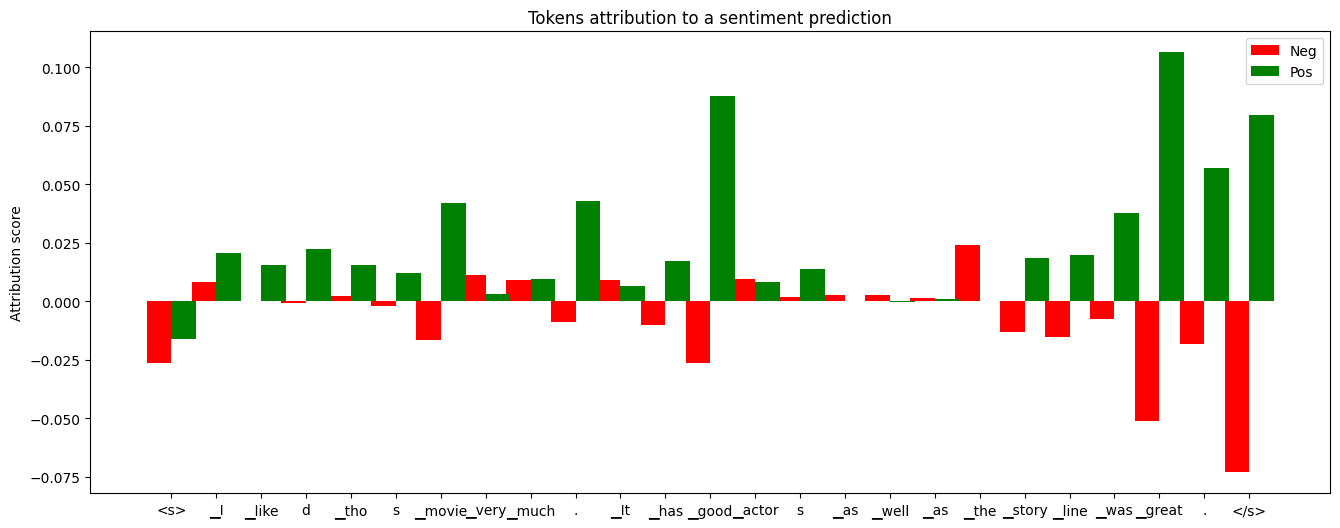

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))

labels = results["tok"]
x = np.arange(len(labels))  # the label locations
width = 0.55  # the width of the bars

rects1 = ax.bar(x - width / 2, results["neg"], width, label="Neg", color="r")
rects2 = ax.bar(x + width / 2, results["pos"], width, label="Pos", color="g")


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Attribution score")
ax.set_title("Tokens attribution to a sentiment prediction")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()